# CLIMATE 405: Machine Learning for Earth and Environmental Sciences; FALL 2024
## Mohammed Ombadi (ombadi@umich.edu)

# Lecture 12 (Wednesday, 10/09/2024)
# Topics covered in this lecture:
- Classification Trees
- Gini Impurity
- Regression Trees
- Random Forests

## Import libraries

In [1]:
# Import libraries
import os
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objects as go
import plotly.express as px
import warnings

from scipy.integrate import odeint
from IPython.display import Image

# Sklearn specific functions used in this lecture
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.tree import plot_tree
from sklearn.metrics import mean_squared_error, r2_score


# Suppress warnings
warnings.filterwarnings('ignore')

# Set number of decimals for np print options
np.set_printoptions(precision=3)

# Set the current working directory
os.chdir(sys.path[0])

## What is a Decision Tree?

<span style="font-size:20px;"> A decision tree is a hierarchical, tree-like model that uses conditional statements to split data into subsets based on feature values.  </span>


We're going to discuss three types of decision trees:
- Classification Trees
- Regression Trees
- Random Forests

## <center> Classification Trees </center>

Import the data:

In [31]:
data = pd.read_csv('partial_correlation_data_annual_categorical.csv')
data.head(n=10)

,year,Precipitation,Evaporation,Streamflow
0,1980,wet,low,high
1,1981,dry,high,low
2,1982,wet,low,high
3,1983,wet,low,high
4,1984,dry,high,low
5,1985,dry,high,low
6,1986,wet,low,low
7,1987,dry,low,low
8,1988,dry,high,low
9,1989,dry,high,low


In [33]:
data[(data['Precipitation']== 'wet') & (data.index < 10)]

,year,Precipitation,Evaporation,Streamflow
0,1980,wet,low,high
2,1982,wet,low,high
3,1983,wet,low,high
6,1986,wet,low,low


First, we need to encode categorical variables to numeric values:

In [34]:
# Define custom mapping for classes
P_mapping = {'dry': 0, 'wet': 1}
E_mapping = {'low': 0, 'high': 1}
S_mapping = {'low': 0, 'high': 1}

# Apply the custom mapping
data['P_encoded'] = data['Precipitation'].map(P_mapping)
data['E_encoded'] = data['Evaporation'].map(E_mapping)
data['S_encoded'] = data['Streamflow'].map(S_mapping)

In [27]:
#from sklearn.preprocessing import LabelEncoder
# We can also use this function which I've already improted. See Import Libraries above.

In [67]:
#le_precip = LabelEncoder()
#le_evap = LabelEncoder()
#le_stream = LabelEncoder()

#df['P_encoded'] = le_precip.fit_transform(df['Precipitation'])
#df['E_encoded'] = le_evap.fit_transform(df['Evaporation'])
#df['S_encoded'] = le_stream.fit_transform(df['Streamflow'])

In [37]:
data.head()


,year,Precipitation,Evaporation,Streamflow,P_encoded,E_encoded,S_encoded
0,1980,wet,low,high,1,0,1
1,1981,dry,high,low,0,1,0
2,1982,wet,low,high,1,0,1
3,1983,wet,low,high,1,0,1
4,1984,dry,high,low,0,1,0


Let's extract features (P and E) and labels (S). Also, let's split the data into training and testing:

In [38]:
# Features (X) and Target (y)
X = data[['P_encoded', 'E_encoded']]
y = data['S_encoded']

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)

In [45]:
np.sum(y_train[y_train==1].values)

10

Now, let's build a classification decision tree model, and use it to predict testing data:

Here is the documentation function we're going to use: [DecisionTreeClassifier](https://scikit-learn.org/dev/modules/generated/sklearn.tree.DecisionTreeClassifier.html)

In [39]:
# Initialize the Decision Tree Classifier
cl_tree = DecisionTreeClassifier()

# Train the classifier
cl_tree.fit(X_train, y_train)

# Make predictions on the test set
y_pred = cl_tree.predict(X_test)

Let's evaluate the model:

In [40]:
results = pd.DataFrame(np.column_stack((y_pred,y_test)), columns= ['y_pred', 'y_test'])
print(results)

   y_pred  y_test
0       1       1
1       1       1
2       0       0
3       0       1
4       0       0


A more formal evaluation:

In [41]:
# Evaluate the model
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))

print("\nClassification Report:")
print(classification_report(y_test, y_pred))

Confusion Matrix:
[[2 0]
 [1 2]]

Classification Report:
              precision    recall  f1-score   support

           0       0.67      1.00      0.80         2
           1       1.00      0.67      0.80         3

    accuracy                           0.80         5
   macro avg       0.83      0.83      0.80         5
weighted avg       0.87      0.80      0.80         5



Finally, let's visulaize the tree (using the plot_tree function from sklearn.tree):

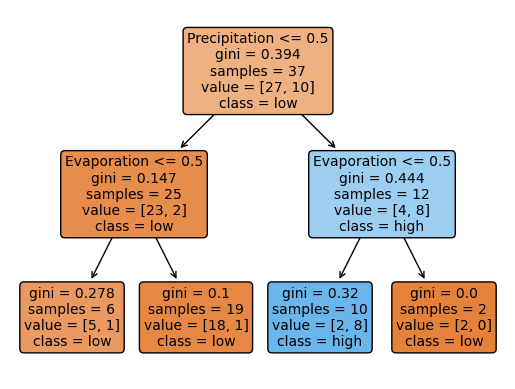

In [10]:
# Plot the decision tree
plot_tree(cl_tree, 
          feature_names=['Precipitation', 'Evaporation'],  # Use original feature names
          class_names= ['low', 'high'],  # Provide class names for target labels
          filled=True,  # Colors the nodes by class
          rounded=True,  # Rounds the node boxes
          fontsize=10)   # Set font size for readability

# Show the plot
plt.show()

#### What is Gini? 

$$
\text{Gini Impurity} = 1 - \sum_{i=1}^{C} p_i^2
$$

Where:
- $p_i$ is the proportion of items belonging to class _i_ 
- C is the number of classes

For the second leaf node (from the left):
$$ Gini = 1 - (1/19)^2 - (18/19)^2 = 0.1 $$

## <center> Regression Trees </center>

Import the data (original values not categorical):

In [46]:
data = pd.read_csv('partial_correlation_data_annual.csv')
data.head()

,year,P,S,E
0,1980,1003,3276,1260
1,1981,346,170,1395
2,1982,944,860,1208
3,1983,1111,2500,1190
4,1984,454,189,1313


In [60]:
# Features (X) and Target (y)
X = data[['P', 'E']]
y = data['S']

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)

Here is the documentation function we're going to use: [DecisionTreeRegressor](https://scikit-learn.org/dev/modules/generated/sklearn.tree.DecisionTreeRegressor.html)

In [61]:
# Initialize the Decision Tree Regressor
regressor = DecisionTreeRegressor()

# Train the regressor
regressor.fit(X_train, y_train)

# Make predictions on the test set
y_pred = regressor.predict(X_test)

In [62]:
results = pd.DataFrame(np.column_stack((y_pred,y_test)), columns= ['y_pred', 'y_test'])
print(results)

   y_pred  y_test
0   863.0  3291.0
1  3276.0  5003.0
2   118.0   182.0
3   608.0  1292.0
4   263.0   189.0


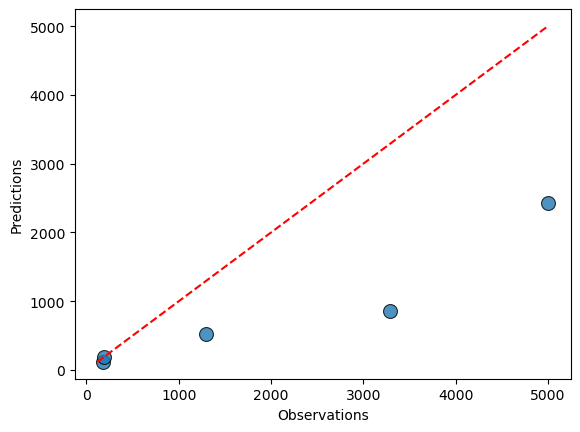

In [58]:
sns.scatterplot(results, x= y_test, y= y_pred, s= 100, alpha= 0.8, edgecolor= 'black')
plt.xlabel('Observations')
plt.ylabel('Predictions')

# Plot the one-to-one line (y = x)
min_val = min(min(y_test), min(y_pred))
max_val = max(max(y_test), max(y_pred))
plt.plot([min_val, max_val], [min_val, max_val], color='red', linestyle='--', label='1:1 Line')

A more formal evaluation:

In [63]:
# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Mean Squared Error: {mse}")
print(f"R-squared: {r2}")

Mean Squared Error: 1871028.2
R-squared: 0.47355570905400524


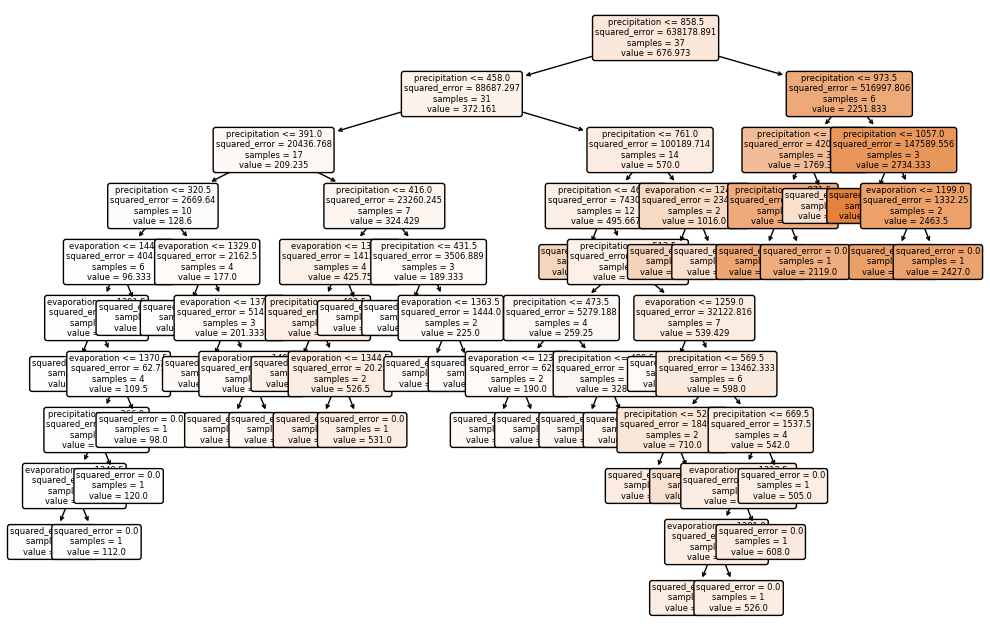

In [53]:
# Set figure size for better visibility
plt.figure(figsize=(12, 8))

# Plot the regression tree
plot_tree(regressor, 
          feature_names=['precipitation', 'evaporation'],  # Names of the features
          filled=True,  # Fills nodes with color based on the output
          rounded=True,  # Rounds the node boxes
          fontsize=6)  # Font size for readability

# Show the plot
plt.show()

### Properties of a Decision Tree:

Depth of the Tree:

In [54]:
regressor.get_depth()

10

Number of leaf nodes:

In [55]:
regressor.get_n_leaves()

37

## <center> Random Forests </center>

Random Forest is an algorithm based on the concept of decision trees. It constructs a large number of decision trees, using subsets of the features and training dataset. The prediction of the random forest is based on the average prediction from the collection of all decision trees.

Let's use random forest from sklearn to revisit the previous example:

The function documentation is available [here](https://scikit-learn.org/1.5/modules/generated/sklearn.ensemble.RandomForestRegressor.html)

In [69]:
# Initialize the Random Forest Regressor
rf_regressor = RandomForestRegressor(n_estimators=100, random_state=42)

# Train the Random Forest model
rf_regressor.fit(X_train, y_train)

# Make predictions on the test set
y_pred = rf_regressor.predict(X_test)

In [70]:
# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Mean Squared Error: {mse}")
print(f"R-squared: {r2}")

Mean Squared Error: 2023022.3748400002
R-squared: 0.43078966971715005


Text(0, 0.5, 'Predictions')

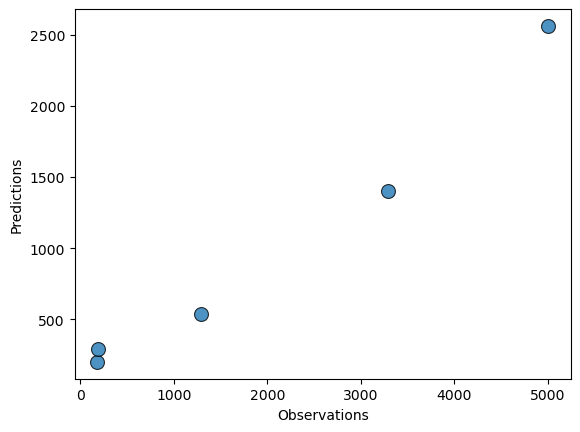

In [71]:
sns.scatterplot(results, x= y_test, y= y_pred, s= 100, alpha= 0.8, edgecolor= 'black')
plt.xlabel('Observations')
plt.ylabel('Predictions')

# Plot the one-to-one line (y = x)
#min_val = min(min(y_test), min(y_pred))
#max_val = max(max(y_test), max(y_pred))
#plt.plot([min_val, max_val], [min_val, max_val], color='red', linestyle='--', label='1:1 Line')

In [72]:
rf_regressor.estimators_

[DecisionTreeRegressor(max_features=1.0, random_state=1608637542),
 DecisionTreeRegressor(max_features=1.0, random_state=1273642419),
 DecisionTreeRegressor(max_features=1.0, random_state=1935803228),
 DecisionTreeRegressor(max_features=1.0, random_state=787846414),
 DecisionTreeRegressor(max_features=1.0, random_state=996406378),
 DecisionTreeRegressor(max_features=1.0, random_state=1201263687),
 DecisionTreeRegressor(max_features=1.0, random_state=423734972),
 DecisionTreeRegressor(max_features=1.0, random_state=415968276),
 DecisionTreeRegressor(max_features=1.0, random_state=670094950),
 DecisionTreeRegressor(max_features=1.0, random_state=1914837113),
 DecisionTreeRegressor(max_features=1.0, random_state=669991378),
 DecisionTreeRegressor(max_features=1.0, random_state=429389014),
 DecisionTreeRegressor(max_features=1.0, random_state=249467210),
 DecisionTreeRegressor(max_features=1.0, random_state=1972458954),
 DecisionTreeRegressor(max_features=1.0, random_state=1572714583),
 De

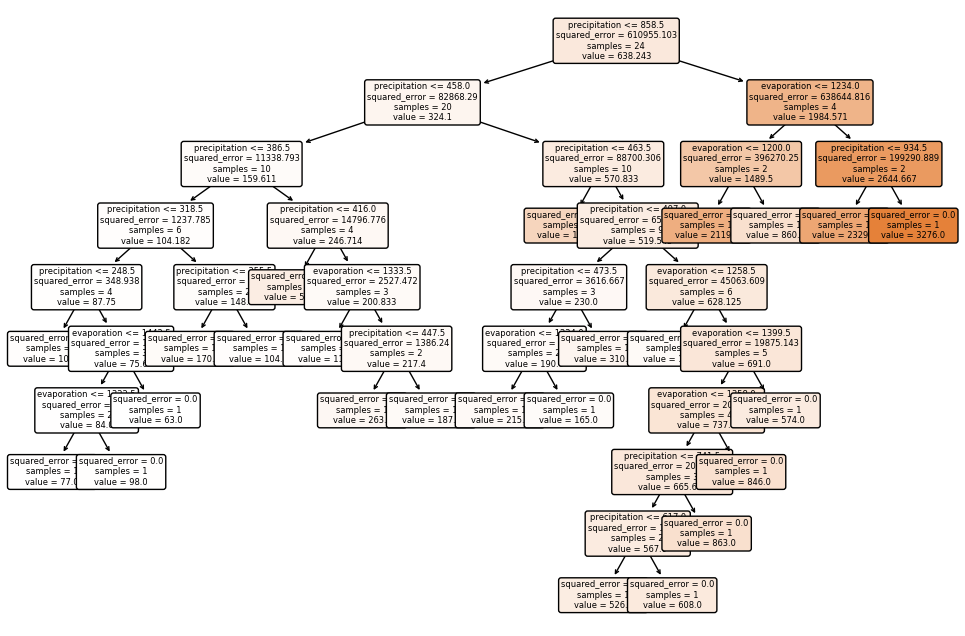

In [74]:
# Set figure size for better visibility
plt.figure(figsize=(12, 8))

# Plot the regression tree
plot_tree(rf_regressor.estimators_[45], 
          feature_names=['precipitation', 'evaporation'],  # Names of the features
          filled=True,  # Fills nodes with color based on the output
          rounded=True,  # Rounds the node boxes
          fontsize=6)  # Font size for readability

# Show the plot
plt.show()